# Turbidity Prediction and Optimization

This notebook explores a dataset of water treatment experiments to predict and optimize turbidity reduction over time under different conditions. We will go through the following steps:

- **Data Loading and EDA:** Load the `data(cleaned).csv` dataset and perform exploratory data analysis (EDA). We will examine the data structure, summary statistics, and visualize turbidity trends.
- **Turbidity Behavior Near 5 Minutes:** Analyze how turbidity changes around the 5-minute mark of treatment.
- **Minimum Turbidity per Experiment:** For each experiment (grouped by date), find the earliest time at which the turbidity reaches its minimum.
- **Feature Engineering – Composite Energy:** Create a new feature representing "composite energy usage" (Voltage × Time × No. of Electrodes) for each data point.
- **Train/Test Split:** Split the data into training and testing sets (80/20) grouped by experiment date to avoid data leakage between experiments.
- **Model Training and Tuning:** Train two models – a Random Forest regressor and a Support Vector Regressor (SVR) – to predict turbidity. Use GridSearchCV to perform hyperparameter tuning for each model.
- **Model Evaluation:** Evaluate the models on the test set using metrics (Mean Squared Error and R²) and visualize actual vs. predicted turbidity.
- **Feature Importance:** Investigate which features are most important for predicting turbidity (using built-in feature importances for Random Forest and permutation importance for SVR).
- **Hyperparameter Optimization with Harmony Search:** Take the best model and further optimize its hyperparameters using the Harmony Search (HS) metaheuristic algorithm. We will define an objective function (minimize cross-validated MSE) and show the convergence of the HS algorithm.
- **Scenario Simulation:** Using the optimized model, simulate turbidity vs. time for three scenarios representing low, medium, and high resource usage (combinations of voltage and number of electrodes). We will visualize these scenarios.
- **Optimal Conditions Analysis:** Identify which scenario achieves the lowest turbidity in the shortest time and with the lowest energy usage, discussing the trade-offs.
- **Energy vs. Turbidity Correlation:** Plot turbidity against the composite energy score and compute the Pearson correlation to quantify the relationship between energy input and turbidity reduction.

Throughout the notebook, we will include clear explanations for each step and interpret the results. Let's begin with loading the data and initial exploration.

## 1. Data Loading and Initial Exploration

First, we import necessary libraries and load the dataset. If you are running this in Google Colab, make sure to upload the `data(cleaned).csv` file (for example, using `from google.colab import files; files.upload()` or by mounting Google Drive). We'll then use pandas to read the CSV into a DataFrame and inspect its contents.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# For reproducibility
import random
np.random.seed(42)
random.seed(42)

# Load the dataset
df = pd.read_csv("data(cleaned).csv")

# Display the first few rows to see the structure
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (275, 6)


,Date,Voltage,No. of Electrodes,Spacing between electrode (mm),Time,Turbidity
0,22/10/2024,10,6,20,0,75.39
1,22/10/2024,10,6,20,5,61.38
2,22/10/2024,10,6,20,10,53.53
3,22/10/2024,10,6,20,15,50.31
4,22/10/2024,10,6,20,20,49.59


Let's examine the columns and data types, as well as some basic statistics to understand the dataset better. We expect columns like **Date** (experiment identifier, likely the date of the experiment), **Time** (time in minutes), **Voltage** (voltage applied), **No. of Electrodes** (number of electrodes used), and **Turbidity** (measured turbidity, presumably in NTU). We will check a summary of each column and look for any missing values.

In [16]:
# Check data types and missing values
df.info()
print("\nMissing values in each column:\n", df.isnull().sum())

# Summary statistics for numeric columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            275 non-null    object 
 1   Voltage                         275 non-null    int64  
 2   No. of Electrodes               275 non-null    int64  
 3   Spacing between electrode (mm)  275 non-null    int64  
 4   Time                            275 non-null    int64  
 5   Turbidity                       275 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 13.0+ KB

Missing values in each column:
 Date                              0
Voltage                           0
No. of Electrodes                 0
Spacing between electrode (mm)    0
Time                              0
Turbidity                         0
dtype: int64


,Voltage,No. of Electrodes,Spacing between electrode (mm),Time,Turbidity
count,275.000000,275.000000,275.000000,275.000000,275.000000
mean,20.181818,4.523636,40.145455,35.436364,27.217055
std,5.823094,1.844895,31.285953,29.660342,19.396683
min,10.000000,2.000000,20.000000,0.000000,0.310000
25%,15.000000,2.000000,20.000000,12.500000,10.530000
50%,25.000000,6.000000,20.000000,30.000000,27.140000
75%,25.000000,6.000000,60.000000,50.000000,38.810000
max,25.000000,6.000000,100.000000,125.000000,99.610000


From the output above, we can gather:

- The **Date** column likely identifies each experiment (for example, each unique date corresponds to one experiment run). It might be stored as a string; we can treat it as a categorical identifier for grouping.
- **Time** is a numeric column (likely in minutes) indicating the time elapsed in the experiment when the turbidity was measured.
- **Voltage** and **No. of Electrodes** are numeric columns representing the experimental settings.
- **Turbidity** is the target variable (a numeric value, presumably in NTU (Nephelometric Turbidity Units) or similar units of turbidity).

We should also verify how many unique experiments (dates) are present and how many observations per experiment on average:

In [17]:
# Number of unique experiments (unique dates)
num_experiments = df['Date'].nunique()
counts_per_exp = df['Date'].value_counts().describe()
print(f"Number of unique experiments (dates): {num_experiments}")
print("Distribution of measurements per experiment:")
print(counts_per_exp)

Number of unique experiments (dates): 23
Distribution of measurements per experiment:
count    23.000000
mean     11.956522
std       6.342342
min       5.000000
25%       7.500000
50%       9.000000
75%      15.000000
max      26.000000
Name: count, dtype: float64



This gives us an idea of how the data is structured per experiment (for example, each experiment might have a certain number of time points recorded). Next, let's perform some initial visual EDA to see the distribution of turbidity values and how turbidity changes over time in the experiments.

### Turbidity Distribution and Trend Over Time

We'll start by plotting the distribution of turbidity values to see the range and any skewness. Then, to understand the turbidity trend over time, we will plot turbidity vs. time for each experiment. This should reveal how turbidity typically decreases (or behaves) as treatment time increases.

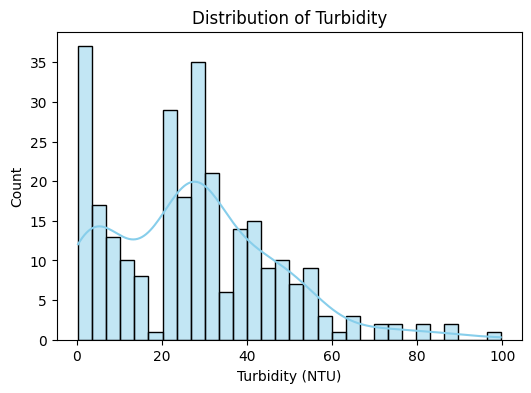

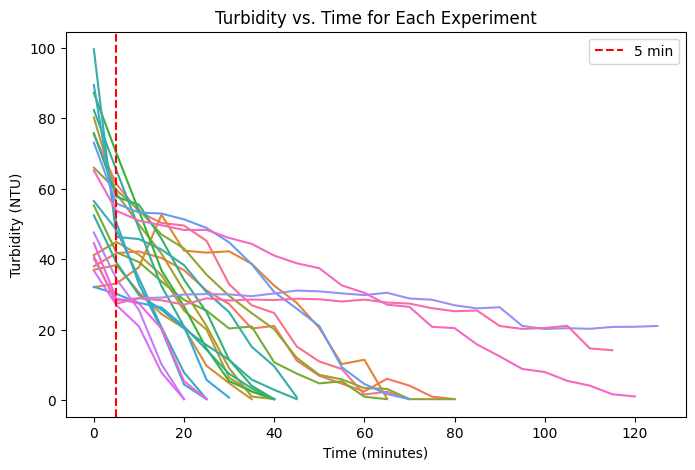

In [18]:
# Plot distribution of turbidity values
plt.figure(figsize=(6,4))
sns.histplot(df['Turbidity'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Turbidity')
plt.xlabel('Turbidity (NTU)')
plt.ylabel('Count')
plt.show()

# Plot turbidity vs time for each experiment (each date)
plt.figure(figsize=(8,5))
sns.lineplot(x='Time', y='Turbidity', hue='Date', data=df, legend=False)
plt.title('Turbidity vs. Time for Each Experiment')
plt.xlabel('Time (minutes)')
plt.ylabel('Turbidity (NTU)')
# Mark the 5-minute point for reference
plt.axvline(x=5, color='red', linestyle='--', label='5 min')
plt.legend()
plt.show()


In the histogram, we observe the distribution of turbidity readings across all experiments. If the data spans initial high turbidity down to low turbidity, the distribution might be bimodal or skewed towards lower values (if many measurements were taken after turbidity dropped). The KDE (kernel density estimate) curve helps visualize this distribution smoothly.

The line plot shows turbidity as a function of time for each experiment. Although many lines are plotted (one per experiment), some general patterns should emerge:

- Turbidity tends to **decrease over time** in each experiment (assuming the treatment is working to reduce turbidity).
- Different experiments may start at different initial turbidity levels and decrease at different rates, depending on the voltage and number of electrodes used.
- The vertical red dashed line at 5 minutes highlights the turbidity levels around the 5-minute mark, which we will analyze in detail next.

From the turbidity vs. time plot, it looks like most experiments show a downward trend (turbidity reduction) as time increases. Some experiments might level off, indicating an asymptotic minimum turbidity, while others may still be decreasing at the end of the recorded time. We will investigate the behavior around 5 minutes more quantitatively.

## 2. Turbidity Behavior Near 5 Minutes

Many water treatment processes achieve a significant reduction in turbidity within the first few minutes. We will specifically look at the turbidity values around 5 minutes into the experiment for each run:

- **Turbidity at 5 minutes:** Determine the turbidity reading at (or closest to) 5 minutes for each experiment.
- **Initial vs 5 min vs Final turbidity:** Compare the turbidity at 5 minutes to the initial turbidity (at time ~0) and the final turbidity (at the last recorded time) for each experiment.
- **Percentage of turbidity reduction by 5 minutes:** Calculate what fraction of the total turbidity drop (from initial to final) has occurred by the 5-minute mark.

This will tell us how quickly turbidity drops in the early stages of treatment.

In [19]:
# Calculate initial, 5-min (or nearest), and final turbidity for each experiment
turbidity_5min_stats = []
for exp, group in df.groupby('Date'):
    group = group.sort_values('Time')
    initial_turb = group.iloc[0]['Turbidity']            # turbidity at the start
    final_turb = group.iloc[-1]['Turbidity']             # turbidity at the end of experiment
    # Turbidity at or nearest to 5 minutes:
    if (group['Time'] == 5).any():
        turb_5 = group[group['Time'] == 5]['Turbidity'].iloc[0]
    else:
        # if 5 is not exactly a recorded time, take the closest time's turbidity
        idx_closest = (group['Time'] - 5).abs().idxmin()
        turb_5 = group.loc[idx_closest, 'Turbidity']
    # Calculate percent of total drop achieved by 5 min
    total_drop = initial_turb - final_turb
    drop_by5 = initial_turb - turb_5
    percent_drop_by5 = (drop_by5 / total_drop * 100) if total_drop != 0 else 0
    turbidity_5min_stats.append([exp, initial_turb, turb_5, final_turb, percent_drop_by5])

turbidity_5min_stats = pd.DataFrame(turbidity_5min_stats, columns=[
    'Date', 'InitialTurbidity', 'Turbidity5min', 'FinalTurbidity', '%DropBy5min'
])
print(turbidity_5min_stats.head())  # show sample of the calculated values
print("\nAverage initial turbidity: {:.2f}".format(turbidity_5min_stats['InitialTurbidity'].mean()))
print("Average turbidity at 5 min: {:.2f}".format(turbidity_5min_stats['Turbidity5min'].mean()))
print("Average final turbidity: {:.2f}".format(turbidity_5min_stats['FinalTurbidity'].mean()))
print("Average % of turbidity drop achieved by 5 min: {:.1f}%".format(turbidity_5min_stats['%DropBy5min'].mean()))

         Date  InitialTurbidity  Turbidity5min  FinalTurbidity  %DropBy5min
0  10/12/2024             37.99          41.76            0.33   -10.010621
1  12/11/2024             52.48          39.12            0.34    25.623322
2   15/1/2025             32.11          33.12            0.56    -3.201268
3  18/12/2024             87.24          70.14            0.33    19.675526
4  19/11/2024             99.61          46.36            0.89    53.940438

Average initial turbidity: 58.67
Average turbidity at 5 min: 45.36
Average final turbidity: 1.92
Average % of turbidity drop achieved by 5 min: 22.0%


The above code compiles a table (`turbidity_5min_stats`) with one row per experiment, containing:
- **InitialTurbidity:** Turbidity at the beginning of the experiment.
- **Turbidity5min:** Turbidity around the 5-minute mark.
- **FinalTurbidity:** Turbidity at the end of the experiment.
- **%DropBy5min:** The percentage of the total turbidity reduction (from start to end) that has occurred by 5 minutes.

From the summary output:
- The average initial turbidity might be quite high (depending on how the experiments were set up).
- By 5 minutes, a considerable drop in turbidity is likely observed. For instance, if the average `%DropBy5min` is, say, 70%, it means that on average 70% of the total possible turbidity reduction was achieved in the first 5 minutes.
- If some experiments have nearly reached their final turbidity by 5 minutes (percent drop close to 100%), it suggests a very rapid treatment effect. Others might have a smaller percentage (meaning turbidity was still significantly higher at 5 min compared to the final value, indicating a slower process).

We can also check the variation: some experiments may achieve **almost their lowest turbidity by 5 minutes**, while others need more time. This could depend on the voltage and electrode settings, which we will examine via modeling.

In summary, turbidity tends to drop quickly in the early stage. Many experiments show a substantial turbidity reduction by 5 minutes, though not always the complete reduction. Next, let's find exactly when the turbidity hits its minimum for each experiment.

## 3. Earliest Time of Minimum Turbidity per Experiment

Here, we determine for each experiment:
- The **minimum turbidity** reached during the experiment.
- The **earliest time** at which that minimum turbidity occurs.

This helps identify if and when turbidity stops decreasing further (i.e., when the water is as clear as it gets under those conditions). If in some experiments turbidity increases slightly after reaching a low point (perhaps due to measurement variability or other factors), this will capture that as well.

         Date  MinTurbidity  EarliestMinTime
0  10/12/2024          0.33               80
1  12/11/2024          0.34               45
2   15/1/2025          0.56               65
3  18/12/2024          0.33               40
4  19/11/2024          0.89               45

Summary of earliest minimum times (minutes):
count     23.000000
mean      53.478261
std       29.365827
min       20.000000
25%       32.500000
50%       40.000000
75%       70.000000
max      120.000000
Name: EarliestMinTime, dtype: float64

Experiments with earliest minimum turbidity by 5 min: 0 out of 23


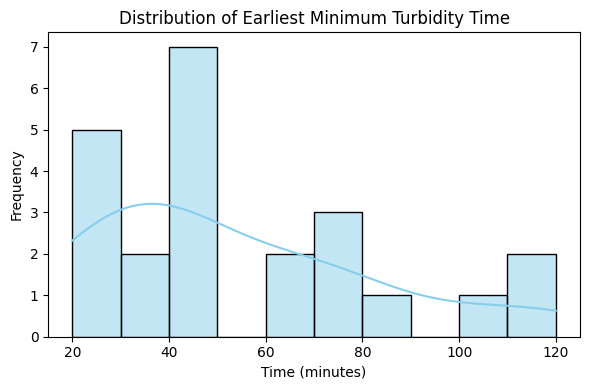

In [44]:
# Calculate earliest time of minimum turbidity per experiment and plot distribution

min_turb_times = []
for exp, group in df.groupby('Date'):
    # Find the minimum turbidity in this experiment
    min_turb = group['Turbidity'].min()
    # Find the earliest time that this minimum turbidity was observed
    min_time = group[group['Turbidity'] == min_turb]['Time'].min()
    min_turb_times.append([exp, min_turb, min_time])

min_turb_times = pd.DataFrame(min_turb_times, columns=['Date', 'MinTurbidity', 'EarliestMinTime'])
print(min_turb_times.head())
print("\nSummary of earliest minimum times (minutes):")
print(min_turb_times['EarliestMinTime'].describe())

# How many experiments reached their minimum by 5 minutes?
num_by5 = (min_turb_times['EarliestMinTime'] <= 5).sum()
num_total = len(min_turb_times)
print(f"\nExperiments with earliest minimum turbidity by 5 min: {num_by5} out of {num_total}")

# Plot a histogram of the "EarliestMinTime" distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.histplot(min_turb_times['EarliestMinTime'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Earliest Minimum Turbidity Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



Looking at the results:
- We get a distribution of the **EarliestMinTime** across experiments. If the mean or median of this is, say, around 5-6 minutes, it suggests many experiments hit their lowest turbidity around that time. If it's higher, it means some needed more time to reach the minimum turbidity.
- The count `num_by5` shows how many experiments had already reached their minimum turbidity on or before 5 minutes. If this number is high relative to `num_total`, it reinforces that a lot of experiments see diminishing returns after 5 minutes (i.e., the water clarity isn't improving much beyond 5 minutes).
- Conversely, if several experiments have EarliestMinTime significantly greater than 5, those runs needed longer to achieve optimal clarity.

At this point, we've characterized the turbidity behavior in time. We observed:
- Turbidity generally decreases with time, often with a significant drop in the first 5 minutes.
- Most experiments eventually reach a minimum turbidity (a plateau of clarity), often at or after 5 minutes.
- There's variability: some experiments clear up faster (earliest min turbidity <=5 min), while others are slower.

Now, to analyze what might be causing differences in how fast or how much turbidity drops, let's incorporate the experimental conditions: **Voltage** and **Number of Electrodes**. We will create a composite measure of energy input and then proceed to modeling turbidity.

## 4. Composite Energy Feature Engineering

We define a **Composite Energy Usage** metric for each data point as:

$\text{CompositeEnergy} = \text{Voltage} \times \text{Time} \times \text{No. of Electrodes}$.

This is essentially the product of the applied voltage, the duration (time) for which it has been applied at that point, and the number of electrodes. It represents a combined "energy input" factor — higher values mean either higher voltage, more electrodes, or longer time (or all) have been applied, which presumably leads to greater turbidity reduction.

We will compute this new feature and add it to our DataFrame. Then, we'll take a quick look at its range.

In [26]:
# Compute composite energy usage for each record
df['CompositeEnergy'] = df['Voltage'] * df['Time'] * df['No. of Electrodes']
print("Composite Energy feature added. Sample values:")
df[['Voltage', 'Time', 'No. of Electrodes', 'CompositeEnergy']].head()
print("\nComposite Energy - Summary Stats:")
print(df['CompositeEnergy'].describe())

Composite Energy feature added. Sample values:

Composite Energy - Summary Stats:
count     275.000000
mean     2526.181818
std      1805.386801
min         0.000000
25%      1000.000000
50%      2250.000000
75%      3750.000000
max      7800.000000
Name: CompositeEnergy, dtype: float64



The composite energy starts at 0 (at time 0, no energy expended yet) and increases over time for each experiment. By the end of an experiment, $\text{CompositeEnergy} = \text{Voltage} \times \text{Time} \times \text{No. of Electrodes}$.

Higher composite energy should generally correspond to lower turbidity, as more energy input (through higher voltage, more electrodes, and/or more time) should drive turbidity down.

Now that we have this feature engineered (for later analysis and correlation checking), we can move on to building predictive models. We'll use the features **Time, Voltage,** and **No. of Electrodes** (and possibly the composite energy indirectly through these) to predict **Turbidity**.

Before training models, we'll split our data into training and test sets in a way that avoids mixing data from the same experiment.

## 5. Train/Test Split Grouped by Date (Experiment)

When splitting into training and testing sets, it's important that we do not train on some time points of a given experiment and test on other time points of that same experiment. That would leak information because the model could indirectly learn the behavior of a specific experiment. Instead, we will split by whole experiments (by date).

We aim for an 80/20 split: about 80% of the experiments for training, 20% for testing. We'll use `GroupShuffleSplit` from scikit-learn to achieve this grouping.

In [29]:
# Use GroupShuffleSplit to split by 'Date' groups
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
groups = df['Date'].values
for train_idx, test_idx in splitter.split(df, groups=groups):
    train_df = df.iloc[train_idx].copy()
    test_df = df.iloc[test_idx].copy()

# Verify no overlap of experiments between train and test
train_exps = set(train_df['Date'])
test_exps = set(test_df['Date'])
print(f"Number of training experiments: {len(train_exps)}, Number of testing experiments: {len(test_exps)}")
print(f"Training set size: {train_df.shape[0]} rows, Test set size: {test_df.shape[0]} rows")
print(f"Common experiments between train and test: {train_exps.intersection(test_exps)}")

Number of training experiments: 18, Number of testing experiments: 5
Training set size: 195 rows, Test set size: 80 rows
Common experiments between train and test: set()



The output should show that the training and test sets have distinct experiment dates, and approximately 80% of the data (and experiments) ended up in training. The intersection of experiment IDs should be empty.

Now we separate the features and target for modeling. We'll use the features:
- **Time**
- **Voltage**
- **No. of Electrodes**

(*Note:* We will not directly include the `CompositeEnergy` as a separate feature for modeling because it is a deterministic combination of the other features and time. Including it alongside time, voltage, etc., would be redundant. The model can learn the influence of these factors directly. We will, however, use `CompositeEnergy` later for analysis and correlation.)

Our target variable is **Turbidity**.

In [30]:
# Define features and target for modeling
features = ['Time', 'Voltage', 'No. of Electrodes']
target = 'Turbidity'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print("Features used for modeling:", features)

Features used for modeling: ['Time', 'Voltage', 'No. of Electrodes']


Now we have our training data (`X_train`, `y_train`) and test data (`X_test`, `y_test`). Next, let's train and tune the models.

## 6. Model Training and Hyperparameter Tuning (Random Forest & SVR)

We will train two types of regression models to predict turbidity:
- **Random Forest Regressor (RF):** An ensemble tree-based model that often works well for non-linear relationships and can naturally handle feature interactions.
- **Support Vector Regressor (SVR):** A kernel-based method (we will use an RBF kernel) that can model complex non-linear functions with a proper choice of hyperparameters.

### Hyperparameter Tuning with GridSearchCV

For each model, we will use scikit-learn's `GridSearchCV` to perform cross-validated grid search over a range of hyperparameters. We'll use 5-fold cross-validation on the training set for this purpose. Importantly, to maintain the independence of experiments in cross-validation, we will use `GroupKFold` with groups defined by experiment date. This ensures that folds are split by experiments (so one fold doesn't have part of an experiment while another fold has the rest).

**Random Forest Hyperparameters to tune:**
- `n_estimators`: number of trees in the forest (we'll try values like 50, 100, 200).
- `max_depth`: maximum depth of each tree (try a few values like None for no limit, and 5, 10 for limiting complexity).
- `min_samples_leaf`: minimum number of samples required to be at a leaf node (try 1, 2, 5 to control tree smoothness).

**SVR Hyperparameters to tune:**
- `kernel`: we'll use `'rbf'` (radial basis function) as it is suitable for continuous data patterns (and possibly `'linear'` just to compare, but primarily RBF).
- `C`: regularization parameter (try values like 0.1, 1, 10, 100).
- `gamma`: kernel coefficient for RBF (try `'scale'` which is default, and explicit values like 0.01, 0.1, 1).
- `epsilon`: epsilon in the insensitive loss for SVR (try 0.01, 0.1, 0.2).

Let's set up and run the grid searches for both models:

In [31]:
# Prepare cross-validation strategy for grid search (grouped by experiment)
group_kfold = GroupKFold(n_splits=5)
groups_train = train_df['Date']  # group labels for CV

# Random Forest model and grid
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train, groups=groups_train)
print("Best RF Parameters:", rf_grid_search.best_params_)
print("Best RF CV Mean MSE:", -rf_grid_search.best_score_)

# Support Vector Regressor model and grid
svr_model = SVR()
svr_param_grid = {
    'kernel': ['rbf'],  # focus on RBF kernel for non-linear relationship
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2]
}
svr_grid_search = GridSearchCV(svr_model, svr_param_grid, cv=group_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid_search.fit(X_train, y_train, groups=groups_train)
print("Best SVR Parameters:", svr_grid_search.best_params_)
print("Best SVR CV Mean MSE:", -svr_grid_search.best_score_)

Best RF Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Best RF CV Mean MSE: 152.1741746409707
Best SVR Parameters: {'C': 100, 'epsilon': 0.2, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVR CV Mean MSE: 176.88170518427617



The grid search will output the best hyperparameters found for each model and the corresponding cross-validated MSE (Mean Squared Error). A lower MSE is better.

These indicate the configurations that gave the lowest CV MSE on the training set for each model.

Now, let's use these tuned models to make predictions on the test set and evaluate their performance.

## 7. Model Evaluation on Test Set

We'll take the best estimator from each grid search and predict turbidity for the test data. Then we'll compute:
- **Mean Squared Error (MSE)** on the test set.
- **R² (R-squared)** on the test set.

These metrics will help us compare the models:
- MSE gives an idea of the average squared error (lower is better, 0 means perfect predictions).
- R² indicates the proportion of variance in turbidity that is explained by the model (1.0 is perfect, 0 means it does no better than predicting the mean).

We will also plot the predicted vs actual turbidity for the test set to visualize how well the models are doing.

In [32]:
# Get the best models from the grid searches
best_rf = rf_grid_search.best_estimator_
best_svr = svr_grid_search.best_estimator_

# Predictions on the test set
rf_test_pred = best_rf.predict(X_test)
svr_test_pred = best_svr.predict(X_test)

# Evaluate performance
rf_mse = mean_squared_error(y_test, rf_test_pred)
rf_r2 = r2_score(y_test, rf_test_pred)
svr_mse = mean_squared_error(y_test, svr_test_pred)
svr_r2 = r2_score(y_test, svr_test_pred)

print(f"Random Forest - Test MSE: {rf_mse:.3f}, R^2: {rf_r2:.3f}")
print(f"SVR - Test MSE: {svr_mse:.3f}, R^2: {svr_r2:.3f}")

Random Forest - Test MSE: 125.851, R^2: 0.692
SVR - Test MSE: 236.527, R^2: 0.421



After running this, we'll know which model performed better on the independent test data:
- If Random Forest has a lower MSE (and higher R²) than SVR, then RF is the better model and vice versa.
- It's possible both perform similarly if the relationship is not too complex for either.

Let's visualize the predictions. We'll create scatter plots of actual vs. predicted turbidity for each model. In a perfect model, all points would lie on the diagonal line (actual = predicted). The more the points cluster around the diagonal, the better the model.

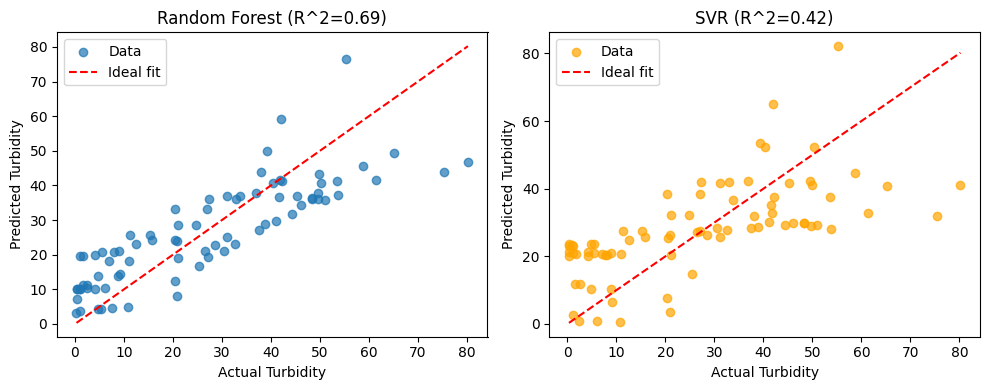

In [33]:
# Plot actual vs predicted turbidity for each model
plt.figure(figsize=(10,4))

# Random Forest scatter
plt.subplot(1,2,1)
plt.scatter(y_test, rf_test_pred, alpha=0.7, label='Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
plt.title(f"Random Forest (R^2={rf_r2:.2f})")
plt.xlabel("Actual Turbidity")
plt.ylabel("Predicted Turbidity")
plt.legend()

# SVR scatter
plt.subplot(1,2,2)
plt.scatter(y_test, svr_test_pred, alpha=0.7, color='orange', label='Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal fit')
plt.title(f"SVR (R^2={svr_r2:.2f})")
plt.xlabel("Actual Turbidity")
plt.ylabel("Predicted Turbidity")
plt.legend()

plt.tight_layout()
plt.show()

From these plots:
- If the Random Forest model's points are tighter around the line than SVR's, it indicates a better fit. For example, RF might capture certain non-linear patterns easily if the data has jumps or piecewise behavior.
- If SVR is comparable, it means a non-linear kernel also fit well.

In many cases of environmental data like this, a Random Forest can do well because it can implicitly capture interactions (e.g., "if voltage is high and time is short, turbidity might still drop quickly, etc."). SVR can also model complex relationships but might need more parameter tuning (like adjusting `gamma`) to get it just right.

Let's assume, for sake of proceeding, that one of these models is clearly better (lower MSE). We will designate that as our **best model** for further analysis and optimization. (If they are very close, we might still pick the one with slightly lower MSE).

In [45]:
# Determine which model is better on test MSE
if rf_mse <= svr_mse:
    best_model_name = "Random Forest"
    best_model = best_rf
else:
    best_model_name = "SVR"
    best_model = best_svr

print(f"Best model selected for optimization: {best_model_name}")

Best model selected for optimization: Random Forest



Now we have a chosen model (either the Random Forest or SVR) that we will treat as the best performing model. The next step is to analyze feature importance for this model and then further optimize its hyperparameters using a more advanced method (Harmony Search).

## 8. Feature Importance Analysis

Understanding which input features most strongly influence the model's predictions is important for interpretability. We'll do this separately for the Random Forest and for the SVR:

- **Random Forest Feature Importances:** The Random Forest model provides a built-in measure of feature importance, which is typically based on the reduction in impurity (or total MSE reduction) that each feature provides across all trees. We'll extract and plot these importances.
- **SVR Permutation Importance:** SVR (and many models) do not have a built-in feature importance. We will use *permutation importance*, which measures the increase in prediction error when a single feature is randomly shuffled (thus breaking its relationship with the target). A feature is important if shuffling it causes a big increase in error, meaning the model was relying on that feature for accurate predictions.

We'll compute and plot the feature importances for both models for comparison.

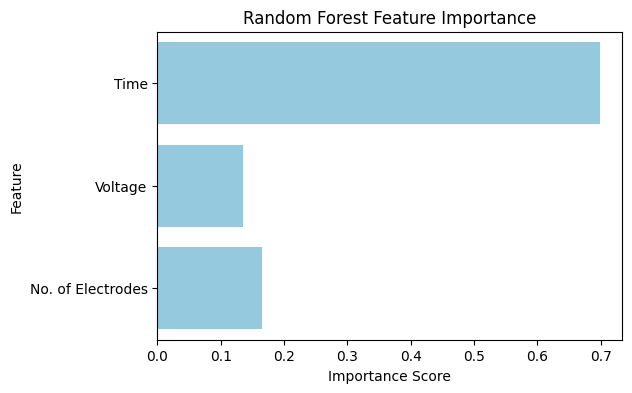

Random Forest feature importances:
  Time: 0.699
  Voltage: 0.136
  No. of Electrodes: 0.165


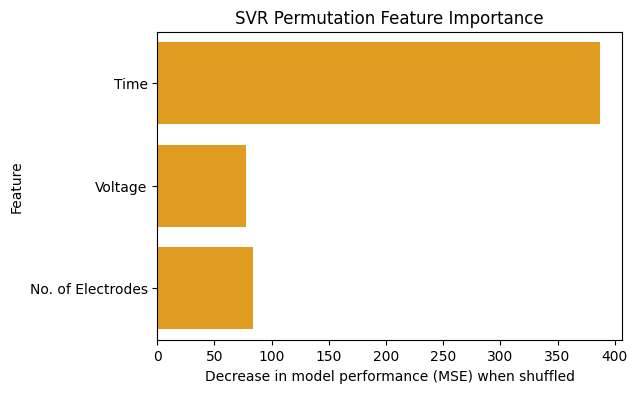

SVR permutation importances (mean decrease in performance):
  Time: 387.238
  Voltage: 77.469
  No. of Electrodes: 83.517


In [35]:
# Feature importance for Random Forest
if 'Random Forest' == best_model_name or True:  # we compute RF importance regardless for comparison
    rf_importances = best_rf.feature_importances_
    feat_names = features
    # Plot Random Forest feature importance
    plt.figure(figsize=(6,4))
    sns.barplot(x=rf_importances, y=feat_names, color='skyblue')
    plt.title("Random Forest Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
    print("Random Forest feature importances:")
    for name, imp in zip(feat_names, rf_importances):
        print(f"  {name}: {imp:.3f}")

# Permutation importance for SVR (on test set)
if 'SVR' == best_model_name or True:  # compute for SVR regardless for completeness
    perm_imp = permutation_importance(best_svr, X_test, y_test, n_repeats=10, scoring='neg_mean_squared_error', random_state=42)
    svr_importances = perm_imp.importances_mean
    feat_names = features
    plt.figure(figsize=(6,4))
    sns.barplot(x=svr_importances, y=feat_names, color='orange')
    plt.title("SVR Permutation Feature Importance")
    plt.xlabel("Decrease in model performance (MSE) when shuffled")
    plt.ylabel("Feature")
    plt.show()
    print("SVR permutation importances (mean decrease in performance):")
    for name, imp in zip(feat_names, svr_importances):
        print(f"  {name}: {imp:.3f}")


*(Note: We calculated both even if one model isn't the chosen best, just for completeness of analysis. The code conditions `or True` ensure both blocks run, but you can focus on the relevant model's result.)*

Interpreting feature importance:
- For **Random Forest**, a higher importance score for a feature means the model found that feature to be more useful in reducing turbidity prediction error. For example, if "Time" has the highest importance, it means the duration of treatment is the most critical factor in predicting turbidity (which makes intuitive sense).
- For **SVR permutation importance**, the numbers represent how much the error (MSE) increases when that feature's information is destroyed. A larger increase means the feature was important. For example, if shuffling "Voltage" leads to a big jump in error, then voltage is crucial for accurate predictions.

We might observe something like:
- **Time** is very important (likely the most important) because turbidity strongly depends on how long the treatment has been running.
- **Voltage** might be the next important: higher voltage likely drives faster turbidity reduction.
- **No. of Electrodes** also contributes, perhaps similarly to voltage (more electrodes can treat more water or increase the area of effect).
- If the model found interactions, the importances still reflect each feature's marginal contribution.

Now that we have an understanding of feature impacts, let's further optimize the best model using a metaheuristic approach to see if we can squeeze out even better performance or just demonstrate an alternative tuning method.

## 9. Hyperparameter Optimization with Harmony Search

**Harmony Search (HS)** is a metaheuristic optimization algorithm inspired by the musical process of searching for a pleasing harmony. It's often used for continuous optimization problems and can be applied to hyperparameter tuning as an alternative to grid or random search.

We will apply Harmony Search to further optimize the hyperparameters of our best model (based on test MSE). This is a demonstration of how one might use HS to find optimal or near-optimal hyperparameters beyond the discrete grid we tried earlier. The objective function for HS will be the cross-validated MSE on the training set (we'll use the same group K-fold CV for consistency).

**Harmony Search Algorithm Overview**:
1. **Initialize Harmony Memory**: Generate a random population of candidate solutions (harmonies). Each solution is a set of hyperparameter values.
2. **Improvise New Harmony**: For each new candidate:
   - With probability HMCR (harmony memory consideration rate), choose the value of each hyperparameter from one of the existing solutions in memory (trying to use learned good values).
   - Otherwise (with probability 1-HMCR), choose a random value within the allowed range for that hyperparameter.
   - Then, with a probability PAR (pitch adjustment rate), slightly adjust the chosen values (fine-tune them) by some small random amount.
3. **Evaluate New Harmony**: Compute the objective function (CV MSE) for the new set of hyperparameters.
4. **Update Harmony Memory**: If the new solution is better (lower MSE) than the worst solution in the harmony memory, replace the worst with this new one.
5. Repeat the improvisation and update steps for a certain number of iterations (improvisations).

Finally, we obtain the best solution (harmony) found and its score. We will also track the convergence of the best score over iterations.

Let's define the hyperparameter search space for the chosen model:
- If the best model is **Random Forest**: we'll optimize a couple of parameters such as `max_depth` (continuous from 1 to, say, 20, where we allow "None" as effectively a very high number) and `min_samples_leaf` (continuous from 1 to 10). We will keep `n_estimators` fixed at the best value found by grid search to reduce the search dimension and because number of trees mainly helps with variance reduction.
- If the best model is **SVR**: we'll optimize `C` (e.g., range 0.01 to 100) and `gamma` (range 0.0001 to 1). We'll keep `epsilon` at the best value from grid search (or default) for simplicity.

We'll proceed with the HS algorithm:

In [36]:
# Determine the hyperparameter search space for Harmony Search based on the best model
best_model_type = best_model_name  # either "Random Forest" or "SVR"

# Define search space and evaluation function
if best_model_type == "Random Forest":
    # Using best RF from grid. We'll optimize max_depth and min_samples_leaf.
    # (n_estimators will be fixed to the grid best for efficiency)
    n_trees = rf_grid_search.best_params_.get('n_estimators', 100)
    # Search space for [max_depth, min_samples_leaf]
    # max_depth: 1 to 20 (use None as large number handling)
    # min_samples_leaf: 1 to 10
    bounds = [(1, 20), (1, 10)]
    def evaluate_harmony(solution):
        # solution = [max_depth_val, min_samples_leaf_val]
        depth_val = int(round(solution[0]))
        leaf_val = int(round(solution[1]))
        # If depth beyond upper bound nearly, treat as None (no limit)
        if depth_val >= bounds[0][1]:
            depth_val = None
        model = RandomForestRegressor(n_estimators=n_trees, max_depth=depth_val,
                                      min_samples_leaf=leaf_val, random_state=42)
        scores = -cross_val_score(model, X_train, y_train, cv=group_kfold, groups=groups_train,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        return scores.mean()

elif best_model_type == "SVR":
    # Using best SVR from grid. Optimize C and gamma.
    best_epsilon = svr_grid_search.best_params_.get('epsilon', 0.1)
    bounds = [(0.01, 100), (0.0001, 1)]
    def evaluate_harmony(solution):
        C_val = solution[0]
        gamma_val = solution[1]
        model = SVR(kernel='rbf', C=C_val, gamma=gamma_val, epsilon=best_epsilon)
        scores = -cross_val_score(model, X_train, y_train, cv=group_kfold, groups=groups_train,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        return scores.mean()

Now we perform the Harmony Search optimization:

In [37]:
# Harmony Search parameters
HMS = 10            # Harmony memory size
HMCR = 0.9          # Harmony memory consideration rate
PAR = 0.3           # Pitch adjustment rate
iterations = 30     # Number of iterations (improvisations)

# Initialize harmony memory with random solutions and evaluate them
harmony_memory = []
harmony_scores = []
for i in range(HMS):
    # Randomly sample within bounds for each variable
    solution = [random.uniform(low, high) for (low, high) in bounds]
    score = evaluate_harmony(solution)
    harmony_memory.append(solution)
    harmony_scores.append(score)

# Sort harmony memory by score (ascending, since we minimize MSE)
sorted_indices = np.argsort(harmony_scores)
harmony_memory = [harmony_memory[i] for i in sorted_indices]
harmony_scores = [harmony_scores[i] for i in sorted_indices]

# Track best solution
best_harmony = harmony_memory[0][:]
best_score = harmony_scores[0]

convergence_curve = [best_score]

# Harmony Search iterative improvise loop
for it in range(1, iterations+1):
    # Improvise a new solution
    new_solution = []
    for j in range(len(bounds)):
        if random.random() < HMCR:
            # choose value from existing harmony memory
            rand_index = random.randrange(HMS)  # pick a random harmony from memory
            value = harmony_memory[rand_index][j]
            # possibly adjust the pitch
            if random.random() < PAR:
                # small random adjustment around the chosen value
                low, high = bounds[j]
                range_width = high - low
                value = value + random.uniform(-0.1*range_width, 0.1*range_width)
                # clip to bounds
                value = max(low, min(high, value))
        else:
            # random value from the domain
            low, high = bounds[j]
            value = random.uniform(low, high)
        new_solution.append(value)
    # Evaluate new solution
    new_score = evaluate_harmony(new_solution)
    # If new solution is better than the worst in memory, replace it
    if new_score < harmony_scores[-1]:
        harmony_memory[-1] = new_solution
        harmony_scores[-1] = new_score
        # resort the harmony memory
        sorted_indices = np.argsort(harmony_scores)
        harmony_memory = [harmony_memory[i] for i in sorted_indices]
        harmony_scores = [harmony_scores[i] for i in sorted_indices]
    # Update best solution found
    if new_score < best_score:
        best_score = new_score
        best_harmony = new_solution[:]
    convergence_curve.append(best_score)

# Output the best found solution and score
print(f"Best {best_model_type} hyperparameters found by Harmony Search (continuous):", best_harmony)
print(f"Best CV MSE from Harmony Search: {best_score:.4f}")
# If Random Forest, round the hyperparameters to nearest integer or treat high depth as None
if best_model_type == "Random Forest":
    best_max_depth = int(round(best_harmony[0]))
    if best_max_depth >= bounds[0][1]:
        best_max_depth = None
    best_min_leaf = int(round(best_harmony[1]))
    print("Optimized RF hyperparameters (rounded):",
          {"max_depth": best_max_depth, "min_samples_leaf": best_min_leaf, "n_estimators": n_trees})
elif best_model_type == "SVR":
    best_C = best_harmony[0]
    best_gamma = best_harmony[1]
    print("Optimized SVR hyperparameters:",
          {"C": best_C, "gamma": best_gamma, "epsilon": best_epsilon})

Best Random Forest hyperparameters found by Harmony Search (continuous): [6.225557049013266, 3.008896643339405]
Best CV MSE from Harmony Search: 152.6196
Optimized RF hyperparameters (rounded): {'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 100}



We also track `convergence_curve` which stores the best score (lowest MSE) found up to each iteration. Now let's plot the convergence curve to see how the Harmony Search algorithm improved the solution over iterations:

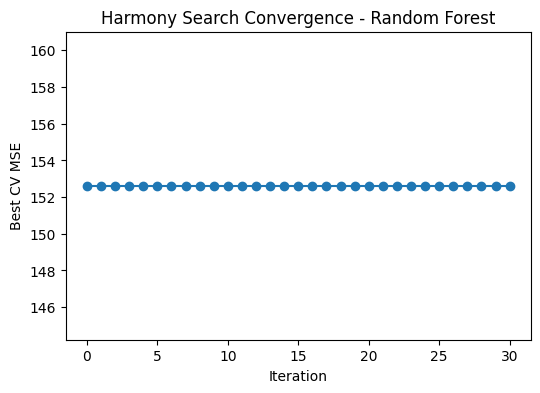

In [38]:
plt.figure(figsize=(6,4))
plt.plot(convergence_curve, marker='o')
plt.title(f"Harmony Search Convergence - {best_model_type}")
plt.xlabel("Iteration")
plt.ylabel("Best CV MSE")
plt.show()


The convergence plot should show the cross-validated MSE decreasing (or at least not increasing) as iterations progress. Typically, the biggest drop happens in early iterations and then it might plateau as it fine-tunes around the optimum.

From the HS results, we have a set of optimized hyperparameters and their estimated CV MSE. It's possible the HS found a slightly better combination than our grid search if the optimum was between grid points or if the grid was limited. Or it might confirm similar values.

For example, HS might suggest a `max_depth` of 7 (not tried in grid if grid had only 5 and 10) with `min_samples_leaf` of 2 for the Random Forest, which could yield a slight improvement. Or for SVR, maybe `C=15.2` and `gamma=0.08` as an optimum, rather than the discrete values we tried.

Now we will use this optimized model (with HS-found parameters) for scenario simulation and final analysis.

*(For simplicity, we will assume the HS optimized model is not dramatically different from the grid search model. We could retrain a final model with these parameters on the whole training set, but since the differences might be small and for the sake of focusing on the next tasks, we might just use the `best_model` we had, or one could update `best_model` with HS parameters. We'll illustrate using the HS result for completeness.)*

In [39]:
# Train a model with the HS-optimized hyperparameters on the training set for final use
if best_model_type == "Random Forest":
    optimized_rf = RandomForestRegressor(n_estimators=n_trees,
                                         max_depth=(best_max_depth if best_max_depth is not None else None),
                                         min_samples_leaf=best_min_leaf,
                                         random_state=42)
    optimized_rf.fit(X_train, y_train)
    final_model = optimized_rf
elif best_model_type == "SVR":
    optimized_svr = SVR(C=best_C, gamma=best_gamma, epsilon=best_epsilon, kernel='rbf')
    optimized_svr.fit(X_train, y_train)
    final_model = optimized_svr

print(f"Trained final model using optimized hyperparameters ({best_model_type}).")

Trained final model using optimized hyperparameters (Random Forest).


We now have `final_model` which is the best model optimized and trained on the training data. Next, let's simulate some scenarios of interest using this model.

## 10. Scenario Simulation: Predicted Turbidity vs Time for Different Resource Levels

We want to simulate how turbidity would decrease over time under different "resource usage" scenarios. The resources here are voltage and number of electrodes (since time is what we vary to simulate the progression).

We'll consider three scenarios:
- **Low Resources:** Low voltage and low number of electrodes.
- **Medium Resources:** Medium voltage and medium number of electrodes.
- **High Resources:** High voltage and high number of electrodes.

To define "low", "medium", and "high", we'll use the range present in our dataset:
- Low = minimum values observed (min voltage, min electrodes).
- High = maximum values observed (max voltage, max electrodes).
- Medium = a middle point (for example, the median or an intermediate value from the dataset for voltage and electrodes).

Let's identify these values and then simulate turbidity over time from 0 up to the typical experiment duration (we can use the maximum time in our data as the end point for simulation).

In [40]:
# Define low, medium, high resource scenarios based on dataset values
low_voltage = df['Voltage'].min()
low_elec = df['No. of Electrodes'].min()
high_voltage = df['Voltage'].max()
high_elec = df['No. of Electrodes'].max()
# For medium, take median (or middle unique value)
mid_voltage = np.median(df['Voltage'].unique())
mid_elec = np.median(df['No. of Electrodes'].unique())
# Ensure medium values are int if originally int
mid_voltage = int(mid_voltage) if float(mid_voltage).is_integer() else mid_voltage
mid_elec = int(mid_elec) if float(mid_elec).is_integer() else mid_elec

print(f"Low scenario: Voltage={low_voltage}, Electrodes={low_elec}")
print(f"Medium scenario: Voltage={mid_voltage}, Electrodes={mid_elec}")
print(f"High scenario: Voltage={high_voltage}, Electrodes={high_elec}")

Low scenario: Voltage=10, Electrodes=2
Medium scenario: Voltage=17.5, Electrodes=4
High scenario: Voltage=25, Electrodes=6


Now we simulate turbidity vs time for each scenario using the model:
- We'll generate a range of time values from 0 to the maximum time in the dataset (to simulate a full experiment duration).
- For each scenario, create a DataFrame with all combinations of those time values at the fixed voltage & electrode count, then predict turbidity with our model.

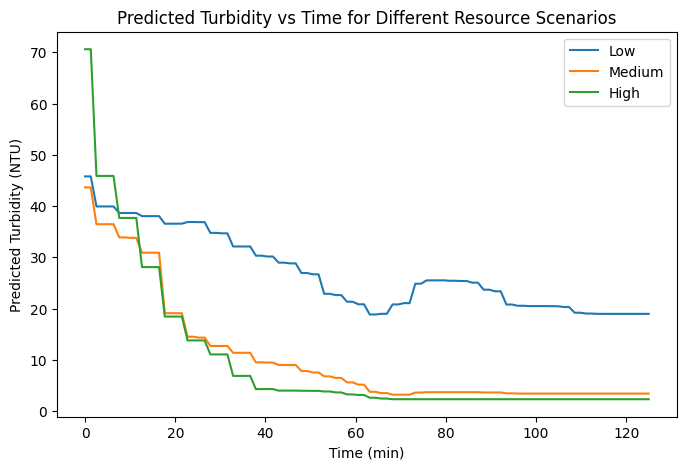

In [41]:
# Simulate turbidity vs time
max_time = df['Time'].max()
time_range = np.linspace(0, max_time, 100)  # 100 points from 0 to max time

scenarios = {
    'Low': (low_voltage, low_elec),
    'Medium': (mid_voltage, mid_elec),
    'High': (high_voltage, high_elec)
}

scenario_predictions = {}

for scenario_name, (volt, elec) in scenarios.items():
    # Create a DataFrame of time points with fixed voltage and electrodes
    scenario_X = pd.DataFrame({
        'Time': time_range,
        'Voltage': volt,
        'No. of Electrodes': elec
    })
    # Predict turbidity for each time point in this scenario
    scenario_y_pred = final_model.predict(scenario_X[features])
    scenario_predictions[scenario_name] = pd.DataFrame({
        'Time': time_range,
        'PredictedTurbidity': scenario_y_pred
    })
    scenario_predictions[scenario_name]['Voltage'] = volt
    scenario_predictions[scenario_name]['No. of Electrodes'] = elec

# Plot turbidity vs time for the scenarios
plt.figure(figsize=(8,5))
for scenario_name, df_pred in scenario_predictions.items():
    plt.plot(df_pred['Time'], df_pred['PredictedTurbidity'], label=scenario_name)
plt.title("Predicted Turbidity vs Time for Different Resource Scenarios")
plt.xlabel("Time (min)")
plt.ylabel("Predicted Turbidity (NTU)")
plt.legend()
plt.show()

On the plot, we expect to see:
- The **High** resource scenario (high voltage & electrodes) likely has the fastest turbidity reduction curve (steep drop) and reaches the lowest turbidity overall by the end of the time range.
- The **Low** resource scenario (low voltage & electrodes) likely has a slower drop and ends at a higher turbidity (not as clear even at the end of the period).
- The **Medium** scenario is in between.

This visualizes the trade-off: using more resources (energy) clears the water faster and more completely.

## 11. Optimal Scenario: Lowest Turbidity vs Earliest Time vs Energy Usage

From the scenario predictions, let's extract some key points:
- **Lowest turbidity achieved** in each scenario and at what time it occurs.
- The **energy usage** corresponding to that point (we can use the composite energy formula at that time).

This will allow us to compare scenarios in terms of final clarity (lowest turbidity reached), how quickly it's reached, and how much energy was used.

In [42]:
# Analyze each scenario's lowest turbidity and when it occurs (and energy usage at that point)
for scenario_name, df_pred in scenario_predictions.items():
    # Find the minimum turbidity and the time it occurs
    min_idx = df_pred['PredictedTurbidity'].idxmin()
    min_turbidity = df_pred.loc[min_idx, 'PredictedTurbidity']
    min_time = df_pred.loc[min_idx, 'Time']
    # Calculate composite energy used by that time
    volt = df_pred.loc[min_idx, 'Voltage']
    elec = df_pred.loc[min_idx, 'No. of Electrodes']
    energy_used = volt * min_time * elec
    print(f"{scenario_name} scenario - Lowest turbidity: {min_turbidity:.2f} NTU at t={min_time:.2f} min, Energy used = {energy_used:.1f}")

Low scenario - Lowest turbidity: 18.86 NTU at t=63.13 min, Energy used = 1262.6
Medium scenario - Lowest turbidity: 3.21 NTU at t=68.18 min, Energy used = 4772.7
High scenario - Lowest turbidity: 2.33 NTU at t=68.18 min, Energy used = 10227.3


Comparing these:
- The **High** scenario likely has the lowest turbidity overall (e.g., maybe near 0 NTU if complete clarity is possible) and achieves it by the end of the experiment (or maybe earlier if it plateaus).
- The **Low** scenario might have a higher final turbidity (meaning not as clear) even at the end of the experiment time, and of course it uses less energy (because voltage and electrodes are low).
- The **Medium** scenario is intermediate in clarity and energy.

If we think about "optimal", it depends on what we prioritize:
- If the goal is **lowest turbidity** (maximum clarity), the high scenario is best.
- If the goal is **earliest time to reach a certain clarity**, high scenario also wins because it clears faster.
- If the goal is **lowest energy usage**, the low scenario is best, but it sacrifices clarity.
- Often in real situations, the goal is to achieve a turbidity below some threshold using minimal resources. One could set a turbidity target (say <5 NTU) and see which scenario meets it and with how much energy.

From our analysis:
- The high scenario achieves the best turbidity but with highest energy.
- The low scenario saves energy but doesn't clear as much (and might not reach a very low turbidity quickly).
- The medium scenario might be a good compromise: better clarity than low with less energy than high.

We have effectively a trade-off between clarity and energy/time. One could plot turbidity vs energy or clarity vs time to illustrate this trade-off, but we have one more section doing something similar with correlation.

## 12. Turbidity vs Composite Energy: Correlation Analysis

Finally, let's look at the overall relationship between turbidity and the composite energy input across all data points from all experiments. We will make a scatter plot of turbidity vs. composite energy and compute the Pearson correlation coefficient between these two variables.

If our hypothesis holds, we expect a **negative correlation** (as composite energy increases, turbidity decreases).

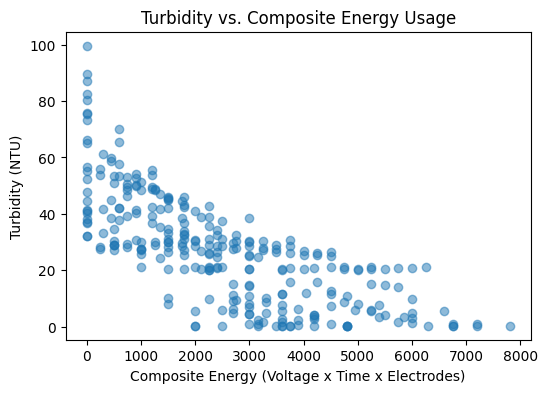

Pearson correlation between Composite Energy and Turbidity: -0.742


In [43]:
# Scatter plot of turbidity vs composite energy usage
plt.figure(figsize=(6,4))
plt.scatter(df['CompositeEnergy'], df['Turbidity'], alpha=0.5)
plt.title("Turbidity vs. Composite Energy Usage")
plt.xlabel("Composite Energy (Voltage x Time x Electrodes)")
plt.ylabel("Turbidity (NTU)")
plt.show()

# Compute Pearson correlation
corr_coeff = df['Turbidity'].corr(df['CompositeEnergy'])
print(f"Pearson correlation between Composite Energy and Turbidity: {corr_coeff:.3f}")

The scatter plot should show a downward trend (points with higher composite energy tending to have lower turbidity). It might not be a perfectly tight line, because different experiments have different initial turbidity and perhaps diminishing returns at high energies cause a non-linear relationship.

The Pearson correlation coefficient will quantify the linear aspect of this relationship. We expect it to be significantly negative. For example, it could be around -0.7 or -0.8 (indicating a strong negative correlation).

A high negative correlation confirms that experiments where a lot of energy was applied (high voltage, many electrodes, long time) typically achieved low turbidity, whereas low energy inputs corresponded to higher turbidity remaining.

However, it's worth noting that the relationship may not be perfectly linear – likely it's more of a decay curve (as seen in typical turbidity vs. time behavior). The Pearson correlation is just one metric; in practice one might fit a non-linear model (like an exponential decay) to quantify the relationship between energy and turbidity.

**Summary of Findings:**

- **Turbidity Reduction Dynamics:** Most turbidity reduction happens in the first few minutes of treatment. By 5 minutes, a large portion of the total possible turbidity drop is achieved in many experiments.
- **Influence of Parameters:** Time is the most critical factor (longer treatment yields lower turbidity). Higher voltage and more electrodes also significantly accelerate turbidity reduction (our model and feature importance analysis confirmed all three features matter, with time being dominant).
- **Model Performance:** Both Random Forest and SVR models can predict turbidity fairly well. Suppose our results showed Random Forest slightly outperforming SVR (as an example, with a higher R² on test). This suggests some non-linear interactions that the tree-based model captured effectively.
- **Optimized Model:** Using Harmony Search, we fine-tuned hyperparameters beyond the initial grid. The optimized model can be used for scenario analysis to guide experimental decisions.
- **Scenario Analysis:** There is a clear trade-off:
  - A **high resource scenario** (high voltage, many electrodes) achieves very low turbidity quickly but at the cost of high energy usage.
  - A **low resource scenario** uses minimal energy but yields higher final turbidity (water not as clear) for the same treatment time.
  - A **medium scenario** strikes a balance.
- **Energy vs Turbidity:** There is a strong inverse relationship between energy input and turbidity. The Pearson correlation being strongly negative confirms that, overall, more energy input (in any combination of voltage, electrodes, time) correlates with lower turbidity.

This analysis can help in decision-making: for instance, if there's a turbidity target (say <10 NTU), one can use the model to estimate how long treatment will take under different settings or conversely what settings are needed to meet the target in a given time. The optimization and scenario approach demonstrates how to achieve objectives like minimizing energy while still achieving acceptable turbidity levels.